In [1]:
import os
import zipfile
import shutil
import random
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import callbacks


In [2]:
from google.colab import drive
drive.mount('/content/drive')

zip_path = '/content/drive/MyDrive/kidney_dataset.zip'
extract_path = '/content/kidney_dataset'

if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall('/content/')

Mounted at /content/drive


In [3]:
#set paths

train_dir = '/content/kidney_dataset/train'
val_dir = '/content/kidney_dataset/val'

In [4]:
#Remove Duplicate Images

import hashlib

def remove_duplicates(directory):
    hashes = set()
    for label in os.listdir(directory):
        class_path = os.path.join(directory, label)
        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            try:
                with open(img_path, 'rb') as f:
                    img_hash = hashlib.md5(f.read()).hexdigest()
                if img_hash in hashes:
                    os.remove(img_path)  # duplicate found, delete
                else:
                    hashes.add(img_hash)
            except:
                print(f"Failed to process {img_path}")

# Apply to both train and val
remove_duplicates(train_dir)
remove_duplicates(val_dir)


In [5]:
#Create Data Generators

IMG_SIZE = 224
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    horizontal_flip=True,
    zoom_range=0.2,
    rotation_range=20
)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)


Found 5844 images belonging to 2 classes.
Found 1470 images belonging to 2 classes.


In [6]:
#Build Model Using ResNet50

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

for layer in base_model.layers:
    layer.trainable = False  # freeze base

model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 23,850,113 (90.98 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [7]:
# Train the model

early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[early_stop]
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 127s 622ms/step - accuracy: 0.7847 - loss: 0.4696 - val_accuracy: 0.9150 - val_loss: 0.2582
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 99s 543ms/step - accuracy: 0.9144 - loss: 0.2402 - val_accuracy: 0.9544 - val_loss: 0.1702
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 97s 529ms/step - accuracy: 0.9408 - loss: 0.1794 - val_accuracy: 0.9673 - val_loss: 0.1268
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 90s 490ms/step - accuracy: 0.9588 - loss: 0.1374 - val_accuracy: 0.9694 - val_loss: 0.1049
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 88s 483ms/step - accuracy: 0.9599 - loss: 0.1227 - val_accuracy: 0.9605 - val_loss: 0.1174
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 88s 481ms/step - accuracy: 0.9694 - loss: 0.1024 - val_accuracy: 0.9755 - val_loss: 0.0894
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 88s 482ms/step - accuracy: 0.9766 - loss: 0.0827 - val_accuracy: 0.9769 - val_loss: 0.0748
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 89s 485ms/step - accuracy: 0.9819 - loss: 

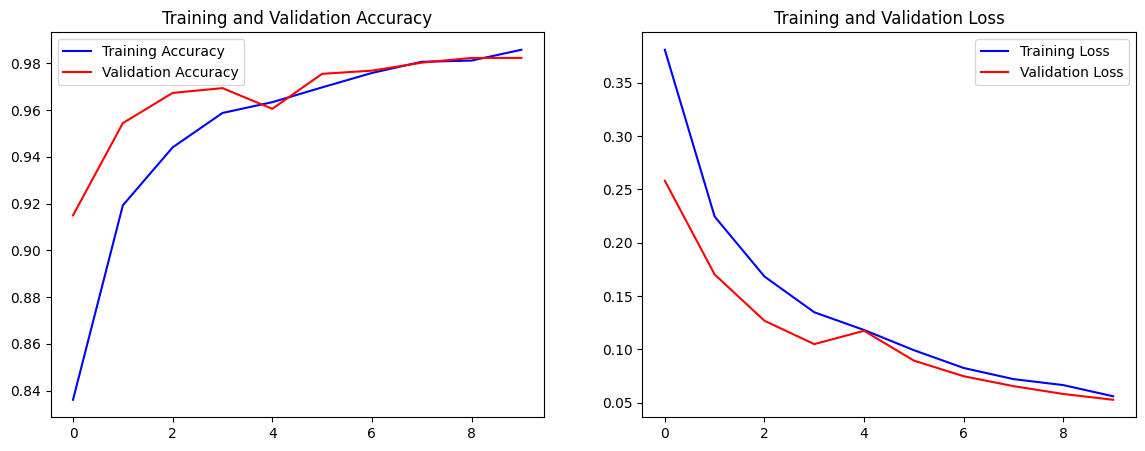

In [8]:
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.show()

plot_training_history(history)


46/46 ━━━━━━━━━━━━━━━━━━━━ 21s 394ms/step


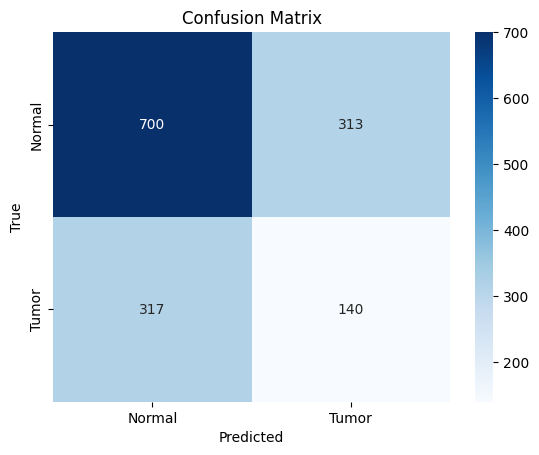

Classification Report:
               precision    recall  f1-score   support

      Normal       0.69      0.69      0.69      1013
       Tumor       0.31      0.31      0.31       457

    accuracy                           0.57      1470
   macro avg       0.50      0.50      0.50      1470
weighted avg       0.57      0.57      0.57      1470



In [9]:
# Get true labels and predictions
val_generator.reset()
Y_pred = model.predict(val_generator)
y_pred = (Y_pred > 0.5).astype(int).reshape(-1)
y_true = val_generator.classes

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Tumor'], yticklabels=['Normal', 'Tumor'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=['Normal', 'Tumor']))


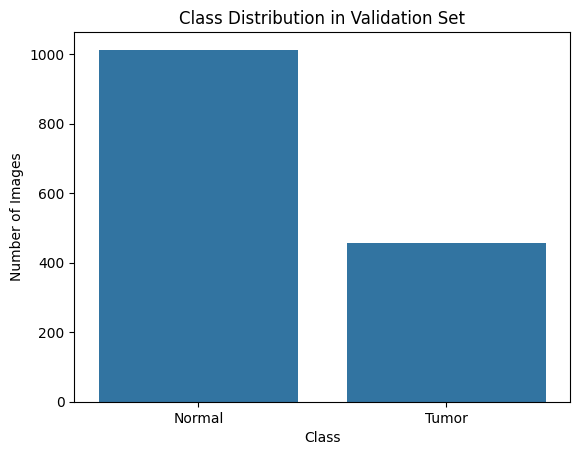

Proportion of Normal images: 0.69
Proportion of Tumor images: 0.31


In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# ... (your existing code) ...

# Class Imbalance Check
class_counts = val_generator.classes
sns.countplot(x=class_counts)
plt.title('Class Distribution in Validation Set')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.xticks([0, 1], ['Normal', 'Tumor'])
plt.show()

# Calculate and print the class proportions
total_samples = len(class_counts)
normal_proportion = sum(class_counts == 0) / total_samples
tumor_proportion = sum(class_counts == 1) / total_samples

print(f"Proportion of Normal images: {normal_proportion:.2f}")
print(f"Proportion of Tumor images: {tumor_proportion:.2f}")


In [11]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(val_generator, verbose=0)
print(f"Test Accuracy: {test_acc}")

# Get the validation accuracy from the training history
val_acc = history.history['val_accuracy'][-1]  # Get the last validation accuracy
print(f"Validation Accuracy: {val_acc}")


Test Accuracy: 0.9823129177093506
Validation Accuracy: 0.9823129177093506


In [12]:
model.save('/content/kidney_cancer_model.h5')
print("Model saved!")


Model saved!


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


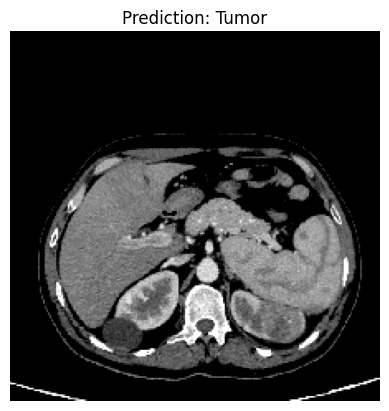

'Tumor'

In [18]:
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# Load the saved model
model = load_model('/content/kidney_cancer_model.h5')

def predict_image(image_path):
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    prediction = model.predict(img_array)
    predicted_class = "Tumor" if prediction[0][0] > 0.5 else "Normal"

    plt.imshow(img)
    plt.title(f"Prediction: {predicted_class}")
    plt.axis('off')
    plt.show()

    return predicted_class

# Example usage (replace with your image path)
image_path = "/content/kidney_dataset/val/Tumor/Tumor- (1136).jpg" #@param {type:"string"}
predict_image(image_path)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


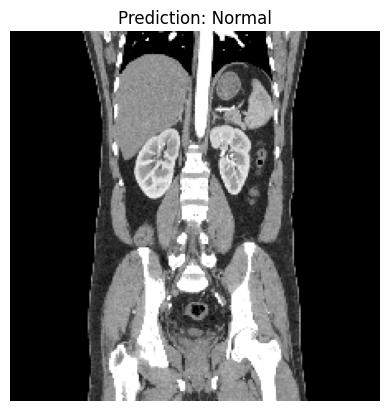

'Normal'

In [19]:
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# Load the saved model
model = load_model('/content/kidney_cancer_model.h5')

def predict_image(image_path):
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    prediction = model.predict(img_array)
    predicted_class = "Tumor" if prediction[0][0] > 0.5 else "Normal"

    plt.imshow(img)
    plt.title(f"Prediction: {predicted_class}")
    plt.axis('off')
    plt.show()

    return predicted_class

# Example usage (replace with your image path)
image_path = "/content/kidney_dataset/val/Normal/Normal- (1024).jpg" #@param {type:"string"}
predict_image(image_path)


In [22]:
import joblib

# Assuming 'val_datagen' is your preprocessor
joblib.dump(val_datagen, '/content/image_preprocessor.pkl')
print("Preprocessor saved!")


Preprocessor saved!


In [24]:
import json

# Save model parameters (example)
model_params = {
    "image_size": IMG_SIZE,
    "batch_size": BATCH_SIZE,
    # Add other relevant parameters
}

with open('/content/model_params.json', 'w') as json_file:
    json.dump(model_params, json_file)
print("Model parameters saved to JSON!")


Model parameters saved to JSON!
